In [2]:
import tensorflow as tf
import numpy as np

tf.__version__

'1.12.0'

In [3]:
from itertools import permutations
import random
import matplotlib.pyplot as plt

In [172]:
class DQN:
    T=1000
    beta=None
    K = 3
    theta_true = [0.65,0.40,0.25]
    theta_possible = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
    tau = 10
    gamma = 55
    
    theta_joint=[]
    pi={}
    
    state = None
    actions = None
    
    input_size = None
    x_input = None
    target_input = None
    history_loss = None
    loss = None
    learning_rate = None
    train_op = None
    prediction = None
    
    iteration = None
    epsilon = None
    
    session = None
    
    def __init__(self, learning_rate = 0.0002, beta = 0.9):
        self.learning_rate = learning_rate
        self.beta = beta
        self.iteration = 0
        self.epsilon = 0.8
        self.history_loss = []
        
        for theta in permutations(self.theta_possible,self.K):
            legal = True
            K = self.K
            for i in range(K-1):
                if theta[i] <= theta[i+1]:
                    legal = False
                    break
            if legal:
                self.theta_joint.append(theta)
        
        for i in range(len(self.theta_joint)):
            self.pi[self.theta_joint[i]] = 1/(len(self.theta_joint))
            
        self.actions = [i for i in range(K)]
        self.state = self.pi
        self.input_size = len(self.theta_joint)+ K
        
        self.create_network()
    
    def create_network(self):
        self.x_input = tf.placeholder(shape=[None,self.input_size], dtype=tf.float32)
        self.target_input = tf.placeholder(shape=[None], dtype=tf.float32)
        
        neural_network_layer_1 = 16
        l1 = self.add_layer(self.x_input, self.input_size, neural_network_layer_1, activation_function=tf.nn.relu)
        
        neural_network_layer_2 = 8
        l2 = self.add_layer(l1, neural_network_layer_1, neural_network_layer_2, activation_function=tf.nn.relu)
        
        self.prediction = self.add_layer(l2, neural_network_layer_2,1,activation_function=None)
        
        self.loss = tf.reduce_mean(tf.reduce_sum(tf.square(self.target_input-self.prediction),reduction_indices=[1]))
        self.train_op = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(init)
    
    def get_action(self):
        a = None
        Q = [self.predict(self.state, i)[0][0] for i in range(self.K)]
        print(Q)
        
        '''a = np.argmin(Q)
        '''
        #self.epsilon = 0
        if random.uniform(0,1)<self.epsilon:
            a = np.random.randint(0,self.K)
        else :
            a = np.argmin(Q)
        if self.iteration%20 == 19 and self.epsilon>0.1:
            self.epsilon -= self.epsilon/20
        
        return a,Q[a]
    
    def get_action2(self):
        estimated_theta = []
        rts = []
        for a in range(self.K):
            prob_Y_y_a = 0.0
            y_a = 1
            for joint in self.theta_joint:
                prob_Y_y_a += self.prob_bernouill(joint[a], y_a)*self.state[joint]
            estimated_theta.append(prob_Y_y_a)
        a = np.argmin(estimated_theta)
        return a,self.predict(self.state, a)[0][0]
    
    def allocate(self, a):
        prob_Y_y_a = 0.0
        y_a = 1
        for joint in self.theta_joint:
            prob_Y_y_a += self.prob_bernouill(joint[a], y_a)*self.state[joint]
            
        rt = self.cost(a) + self.gamma*prob_Y_y_a
        y_a = None
        
        theta = self.theta_true[a]
        if random.uniform(0,1) <= theta:
            y_a = 1
        else:
            y_a = 0
        #rt = self.cost(a) + self.gamma*y_a
        return rt,y_a
        
    
    def prob_bernouill(self, theta, y):
        return np.power(theta, y)*np.power((1-theta), (1-y))
    
    def get_next_state(self, a, y_a):
        prob_Y_y_a = 0.0
        next_state = {}
        for joint in self.theta_joint:
            prob_Y_y_a += self.prob_bernouill(joint[a], y_a)*self.state[joint]
        
        for joint in self.theta_joint:
            theta = joint[a]
            p1 = self.prob_bernouill(theta, y_a)
            next_state[joint] = p1*self.state[joint]/prob_Y_y_a
            
        return next_state
    
    def transition(self, next_state):
        self.state = next_state
    
    def get_target(self, r, next_state):
        Q = [self.predict(next_state, i)[0][0] for i in range(self.K)]
        return self.beta * np.min(Q) + r
            
        
    def train(self,s,a,y):
        self.iteration += 1
        x = self.get_x(s,a)
        _,loss = self.session.run([self.train_op, self.loss], feed_dict={self.x_input:x,self.target_input:y})
        self.history_loss.append(loss)
        return loss
        
    
    def predict(self,s,a):
        x = self.get_x(s,a)
        return self.session.run(self.prediction, feed_dict={self.x_input:x})
    
    def evaluate(self):
        estimated_theta = []
        rts = []
        for a in range(self.K):
            prob_Y_y_a = 0.0
            y_a = 1
            for joint in self.theta_joint:
                prob_Y_y_a += self.prob_bernouill(joint[a], y_a)*self.state[joint]
            estimated_theta.append(prob_Y_y_a)
            rts.append(self.cost(a) + self.gamma*prob_Y_y_a)
        print('  estimated thetas: ', estimated_theta)
        print('  Q               : ', [self.predict(self.state, i)[0][0] for i in range(self.K)])
        print('  rt              : ', rts)
    
    def get_x(self,s,a):
        return np.array([np.append(self.F(s), self.G(a))])
        
    def F(self,s):
        return np.array([s[joint] for joint in self.theta_joint])
    
    def G(self,k):
        r = np.zeros(self.K)
        r[k]=1
        return r
    
    def cost(self,k):
        return 10*(k+1)
    
    def add_layer(self,inputs,in_size,out_size,activation_function=None):
        w = tf.Variable(tf.random_normal([in_size,out_size]))
        b = tf.Variable(tf.zeros([1,out_size])+0.1)
        f = tf.matmul(inputs,w) + b
        if activation_function is None:
            outputs = f
        else:
            outputs = activation_function(f)
        return outputs


In [181]:
dqn = DQN()

In [179]:
dqn.evaluate()

  estimated thetas:  [0.6995061060700978, 0.40052577035404807, 0.24568079485897962]
  Q               :  [428.3734, 420.4911, 421.693]
  rt              :  [48.47283583385538, 42.028917369472644, 43.51244371724388]


In [178]:
t = 800
for i in range(t):
    # get action 
    a_t, Q_t = dqn.get_action()
    # allocate the choix to the client
    r_t, y_t = dqn.allocate(a_t)
    next_state = dqn.get_next_state(a=a_t,y_a=y_t)
    target = dqn.get_target(r_t, next_state)
    print('at: %d  Qt: %.3f  rt: %.3f  yt: %d  target:%.3f'%(a_t,Q_t,r_t,y_t,target))
    dqn.train(dqn.state, a_t, [target])
    dqn.transition(next_state)

[421.02673, 411.60303, 409.95157]
at: 2  Qt: 409.952  rt: 41.008  yt: 1  target:409.935
[420.9328, 411.51196, 409.82407]
at: 2  Qt: 409.824  rt: 41.012  yt: 0  target:409.865
[421.10803, 411.6944, 410.06213]
at: 2  Qt: 410.062  rt: 41.010  yt: 0  target:410.076
[421.173, 411.76044, 410.15036]
at: 2  Qt: 410.150  rt: 41.009  yt: 1  target:410.110
[420.98053, 411.56622, 409.88898]
at: 2  Qt: 409.889  rt: 41.014  yt: 0  target:409.926
[421.14456, 411.7363, 410.11172]
at: 2  Qt: 410.112  rt: 41.012  yt: 0  target:410.124
[421.2027, 411.7947, 410.1907]
at: 2  Qt: 410.191  rt: 41.010  yt: 0  target:410.192
[421.2152, 411.80524, 410.2077]
at: 2  Qt: 410.208  rt: 41.009  yt: 1  target:410.162
[420.99838, 411.58533, 409.91327]
at: 2  Qt: 409.913  rt: 41.014  yt: 0  target:409.948
[421.1531, 411.7455, 410.12338]
at: 2  Qt: 410.123  rt: 41.012  yt: 0  target:410.134
[421.20657, 411.79898, 410.196]
at: 2  Qt: 410.196  rt: 41.010  yt: 1  target:410.148
[420.9754, 411.5653, 409.88214]
at: 2  Qt: 409

at: 2  Qt: 442.477  rt: 41.059  yt: 0  target:439.353
[439.39072, 429.86002, 423.5304]
at: 2  Qt: 423.530  rt: 41.051  yt: 0  target:422.282
[434.0263, 424.1717, 416.3197]
at: 2  Qt: 416.320  rt: 41.045  yt: 1  target:415.552
[430.6043, 420.60275, 411.73135]
at: 2  Qt: 411.731  rt: 41.067  yt: 0  target:411.692
[430.49493, 420.46863, 411.58218]
at: 2  Qt: 411.582  rt: 41.059  yt: 0  target:411.541
[430.37164, 420.3221, 411.4147]
at: 2  Qt: 411.415  rt: 41.052  yt: 0  target:411.376
[430.25165, 420.18103, 411.2519]
at: 2  Qt: 411.252  rt: 41.045  yt: 0  target:411.217
[430.14163, 420.05225, 411.1028]
at: 2  Qt: 411.103  rt: 41.040  yt: 0  target:411.071
[430.0422, 419.93622, 410.96808]
at: 2  Qt: 410.968  rt: 41.035  yt: 0  target:410.940
[429.95444, 419.8339, 410.84918]
at: 2  Qt: 410.849  rt: 41.030  yt: 1  target:410.675
[429.11856, 418.9837, 409.7315]
at: 2  Qt: 409.732  rt: 41.045  yt: 1  target:409.626
[428.52487, 418.4059, 408.9404]
at: 2  Qt: 408.940  rt: 41.068  yt: 0  target:4

at: 2  Qt: 397.908  rt: 41.022  yt: 0  target:399.159
[418.70483, 413.1442, 404.70282]
at: 2  Qt: 404.703  rt: 41.020  yt: 0  target:405.270
[421.0188, 415.60785, 407.84595]
at: 2  Qt: 407.846  rt: 41.017  yt: 1  target:408.017
[421.6612, 416.31747, 408.72537]
at: 2  Qt: 408.725  rt: 41.026  yt: 0  target:408.902
[422.40375, 417.10144, 409.73267]
at: 2  Qt: 409.733  rt: 41.022  yt: 0  target:409.802
[422.70755, 417.41818, 410.1437]
at: 2  Qt: 410.144  rt: 41.020  yt: 0  target:410.167
[422.81906, 417.53033, 410.29346]
at: 2  Qt: 410.293  rt: 41.017  yt: 0  target:410.297
[422.84772, 417.555, 410.33087]
at: 2  Qt: 410.331  rt: 41.015  yt: 0  target:410.327
[422.8424, 417.5441, 410.32227]
at: 2  Qt: 410.322  rt: 41.013  yt: 0  target:410.315
[422.82428, 417.5201, 410.29636]
at: 0  Qt: 422.824  rt: 47.938  yt: 1  target:418.117
[396.82782, 398.07227, 392.19974]
at: 2  Qt: 392.200  rt: 41.012  yt: 0  target:394.001
[403.7966, 405.59787, 401.80527]
at: 2  Qt: 401.805  rt: 41.010  yt: 0  tar

at: 2  Qt: 410.714  rt: 41.026  yt: 0  target:410.695
[429.97476, 418.69943, 410.63162]
at: 2  Qt: 410.632  rt: 41.023  yt: 1  target:410.501
[429.32642, 418.0579, 409.79187]
at: 2  Qt: 409.792  rt: 41.034  yt: 0  target:409.880
[429.74127, 418.4741, 410.32916]
at: 2  Qt: 410.329  rt: 41.030  yt: 0  target:410.356
[429.88177, 418.61075, 410.51123]
at: 2  Qt: 410.511  rt: 41.026  yt: 0  target:410.512
[429.90765, 418.63104, 410.5449]
at: 2  Qt: 410.545  rt: 41.023  yt: 1  target:410.423
[429.2957, 418.02676, 409.75217]
at: 1  Qt: 418.027  rt: 42.054  yt: 0  target:410.945
[397.45456, 377.86334, 379.06915]
at: 1  Qt: 377.863  rt: 42.032  yt: 1  target:381.922
[414.1866, 399.14523, 395.30295]
at: 2  Qt: 395.303  rt: 41.034  yt: 0  target:396.838
[420.6337, 405.69547, 403.66992]
at: 2  Qt: 403.670  rt: 41.030  yt: 0  target:404.361
[423.61176, 408.71854, 407.5368]
at: 2  Qt: 407.537  rt: 41.026  yt: 0  target:407.835
[424.91827, 410.04193, 409.23364]
at: 2  Qt: 409.234  rt: 41.023  yt: 0  

at: 2  Qt: 401.377  rt: 41.600  yt: 0  target:403.397
[424.17267, 414.38574, 412.87714]
at: 2  Qt: 412.877  rt: 41.533  yt: 0  target:413.591
[427.51202, 417.76477, 417.37973]
at: 2  Qt: 417.380  rt: 41.472  yt: 0  target:417.540
[428.56134, 418.73203, 418.7586]
at: 1  Qt: 418.732  rt: 42.054  yt: 0  target:419.036
[430.1176, 420.62488, 420.20972]
at: 2  Qt: 420.210  rt: 41.417  yt: 0  target:419.991
[429.5516, 419.89407, 419.39005]
at: 2  Qt: 419.390  rt: 41.368  yt: 0  target:419.161
[428.90155, 419.08865, 418.46307]
at: 2  Qt: 418.463  rt: 41.325  yt: 0  target:418.244
[428.25717, 418.3024, 417.55017]
at: 2  Qt: 417.550  rt: 41.286  yt: 0  target:417.348
[427.65335, 417.57104, 416.69794]
at: 2  Qt: 416.698  rt: 41.252  yt: 0  target:416.516
[427.1031, 416.90698, 415.92322]
at: 2  Qt: 415.923  rt: 41.222  yt: 1  target:414.745
[421.48187, 411.23047, 408.3954]
at: 2  Qt: 408.395  rt: 41.326  yt: 1  target:407.760
[417.90317, 407.83636, 403.6654]
at: 2  Qt: 403.665  rt: 41.476  yt: 0  

at: 1  Qt: 420.245  rt: 41.992  yt: 1  target:420.165
[422.53986, 419.7424, 424.45456]
at: 1  Qt: 419.742  rt: 42.001  yt: 1  target:419.721
[422.37085, 419.56827, 424.33163]
at: 1  Qt: 419.568  rt: 42.010  yt: 0  target:419.656
[422.80954, 420.10046, 424.73663]
at: 2  Qt: 424.737  rt: 42.284  yt: 0  target:420.979
[408.23047, 404.7096, 405.17328]
at: 1  Qt: 404.710  rt: 42.003  yt: 0  target:406.274
[414.8455, 413.24448, 411.64584]
at: 2  Qt: 411.646  rt: 42.156  yt: 0  target:413.678
[423.92874, 422.4684, 423.96472]
at: 1  Qt: 422.468  rt: 41.998  yt: 0  target:422.250
[423.00812, 421.25168, 423.02524]
at: 0  Qt: 423.008  rt: 48.379  yt: 1  target:427.751
[451.34665, 442.816, 443.6013]
at: 2  Qt: 443.601  rt: 42.039  yt: 0  target:441.166
[441.22293, 432.1998, 430.30194]
at: 2  Qt: 430.302  rt: 41.931  yt: 0  target:430.132
[441.20013, 431.9936, 430.34634]
at: 2  Qt: 430.346  rt: 41.832  yt: 1  target:426.017
[420.20325, 411.03116, 402.40662]
at: 2  Qt: 402.407  rt: 42.160  yt: 0  ta

at: 1  Qt: 419.926  rt: 42.030  yt: 0  target:419.987
[426.60626, 420.2907, 424.3752]
at: 0  Qt: 426.606  rt: 48.366  yt: 1  target:426.784
[427.77695, 421.21985, 425.252]
at: 1  Qt: 421.220  rt: 42.025  yt: 1  target:421.094
[427.18134, 420.4857, 424.6703]
at: 1  Qt: 420.486  rt: 42.032  yt: 0  target:420.493
[427.2629, 420.5536, 424.73602]
at: 1  Qt: 420.554  rt: 42.026  yt: 1  target:420.494
[426.94876, 420.1905, 424.43954]
at: 0  Qt: 426.949  rt: 48.404  yt: 1  target:426.710
[425.74844, 419.32745, 423.5898]
at: 1  Qt: 419.327  rt: 42.033  yt: 1  target:419.391
[425.93835, 419.638, 423.8081]
at: 1  Qt: 419.638  rt: 42.041  yt: 1  target:419.670
[425.97476, 419.76245, 423.87772]
at: 1  Qt: 419.762  rt: 42.052  yt: 1  target:419.781
[425.93082, 419.8001, 423.87402]
at: 1  Qt: 419.800  rt: 42.065  yt: 0  target:419.932
[426.59058, 420.5866, 424.50723]
at: 1  Qt: 420.587  rt: 42.054  yt: 1  target:420.522
[426.19125, 420.1619, 424.1459]
at: 1  Qt: 420.162  rt: 42.067  yt: 0  target:420

Text(0, 0.5, 'loss')

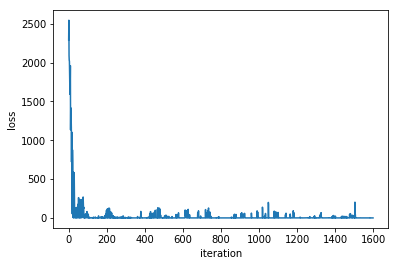

In [180]:
plt.plot([i for i in range(dqn.iteration)], dqn.history_loss)
plt.xlabel('iteration')
plt.ylabel('loss')

In [401]:
dqn.epsilon

0.04763084408442366

In [ ]:
np.power(0.7, 1)*np.power((1-0.7), 0)

In [ ]:
x_data = np.linspace(-1,1,300,dtype=np.float32)[:,np.newaxis]
x_data.shape

In [8]:
al = []
p = 0.6
for i in range(1000):
    t = random.uniform(0,1)
    if t <= 0.6:
        al.append(1)
    else:
        al.append(0)

print(sum(al))

607


In [3]:
a = [1]
list.append(a,1)

In [4]:
a.append(1)

[1, 1]

In [60]:
print('%d %d %.2f'%(2,2, 0.2343))

2 2 0.23


In [147]:
np.random.randint(0,4)

0

In [182]:
dqn.state

{(0.9, 0.8, 0.7): 0.005952380952380952,
 (0.9, 0.8, 0.6): 0.005952380952380952,
 (0.9, 0.8, 0.5): 0.005952380952380952,
 (0.9, 0.8, 0.4): 0.005952380952380952,
 (0.9, 0.8, 0.3): 0.005952380952380952,
 (0.9, 0.8, 0.2): 0.005952380952380952,
 (0.9, 0.8, 0.1): 0.005952380952380952,
 (0.9, 0.7, 0.6): 0.005952380952380952,
 (0.9, 0.7, 0.5): 0.005952380952380952,
 (0.9, 0.7, 0.4): 0.005952380952380952,
 (0.9, 0.7, 0.3): 0.005952380952380952,
 (0.9, 0.7, 0.2): 0.005952380952380952,
 (0.9, 0.7, 0.1): 0.005952380952380952,
 (0.9, 0.6, 0.5): 0.005952380952380952,
 (0.9, 0.6, 0.4): 0.005952380952380952,
 (0.9, 0.6, 0.3): 0.005952380952380952,
 (0.9, 0.6, 0.2): 0.005952380952380952,
 (0.9, 0.6, 0.1): 0.005952380952380952,
 (0.9, 0.5, 0.4): 0.005952380952380952,
 (0.9, 0.5, 0.3): 0.005952380952380952,
 (0.9, 0.5, 0.2): 0.005952380952380952,
 (0.9, 0.5, 0.1): 0.005952380952380952,
 (0.9, 0.4, 0.3): 0.005952380952380952,
 (0.9, 0.4, 0.2): 0.005952380952380952,
 (0.9, 0.4, 0.1): 0.005952380952380952,
